In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [6]:
# ===== Load data =====
red = pd.read_csv("Red.csv")
white = pd.read_csv("White.csv")
rose = pd.read_csv("Rose.csv")
sparkling = pd.read_csv("Sparkling.csv")
varieties = pd.read_csv("Varieties.csv")

# Assign WineStyle and combine
red["WineStyle"]       = "Red"
white["WineStyle"]     = "White"
rose["WineStyle"]      = "Rose"
sparkling["WineStyle"] = "Sparkling"
df = pd.concat([red, white, rose, sparkling], ignore_index=True)

# Impute Age
df["IsNV"] = df["Year"] == "N.V."
valid_year = df[df["Year"] != "N.V."].copy()
valid_year["Year"] = valid_year["Year"].astype(int)
valid_year["Age"]  = 2025 - valid_year["Year"]
avg_age = valid_year.groupby("WineStyle")["Age"].mean()

def impute_age(row):
    if row["IsNV"]:
        return avg_age.get(row["WineStyle"], valid_year["Age"].mean())
    try:
        return 2025 - int(row["Year"])
    except:
        return np.nan

df["Age"] = df.apply(impute_age, axis=1)

# Extract Variety
variety_list = varieties["Variety"].dropna().unique().tolist()

def extract_variety(name):
    for v in variety_list:
        if isinstance(name, str) and v.lower() in name.lower():
            return v
    return "Unknown"

df["Variety"] = df["Name"].apply(extract_variety).fillna("Unknown")

# Drop missing
df = df.dropna(subset=["Rating", "Price", "Country", "Region", "Winery", "WineStyle", "Age"])

# Create SmoothedRating
global_mean = df["Rating"].mean()
df["SmoothedRating"] = (df["Rating"] * df["NumberOfRatings"] + global_mean * 5) / (df["NumberOfRatings"] + 5)

# Assign ReliabilityGroup
def reliability_group(n):
    if n < 35:
        return "Low"
    elif n < 838:
        return "Medium"
    else:
        return "High"

df["ReliabilityGroup"] = df["NumberOfRatings"].apply(reliability_group)

# Basic features
df["LogPrice"]            = np.log1p(df["Price"])
df["PricePerAge"]         = df["Price"] / (df["Age"] + 1)
df["IsOld"]               = df["Age"] > 10
df["WineryFreq"]          = df["Winery"].map(df["Winery"].value_counts() / len(df))
df["RegionFreq"]          = df["Region"].map(df["Region"].value_counts() / len(df))
df["CountryFreq"]         = df["Country"].map(df["Country"].value_counts() / len(df))
df["PriceAgeInteraction"] = df["PricePerAge"] * df["LogPrice"]
df["LogLogPrice"]         = np.log1p(df["LogPrice"])

df["LogNumberOfRatings"] = np.log1p(df["NumberOfRatings"])
df["RatingSupportScore"] = df["NumberOfRatings"] / (df["Age"] + 1)

# ————— Thêm VarietyFreq (tần suất xuất hiện của mỗi giống nho) —————
df["VarietyFreq"] = df["Variety"].map(df["Variety"].value_counts() / len(df))

# ===== 1.1. Country-level: tính trung bình SmoothedRating, xếp hạng, chuẩn hóa Score ∈ [0,1] =====
country_agg = (
    df.groupby("Country")["SmoothedRating"]
      .mean()
      .reset_index()
      .rename(columns={"SmoothedRating": "Country_MeanRating"})
)
country_agg["Country_Rank"] = country_agg["Country_MeanRating"]\
    .rank(method="first", ascending=False).astype(int)

max_rank_country = country_agg["Country_Rank"].max()
if max_rank_country > 1:
    country_agg["Country_Score"] = (max_rank_country - country_agg["Country_Rank"]) / (max_rank_country - 1)
else:
    # Nếu chỉ có duy nhất 1 country, gán score = 1.0 cho tất cả
    country_agg["Country_Score"] = 1.0

df = df.merge(
    country_agg[["Country", "Country_MeanRating", "Country_Rank", "Country_Score"]],
    how="left", on="Country"
)

# ===== 1.2. Region-level =====
region_agg = (
    df.groupby("Region")["SmoothedRating"]
      .mean()
      .reset_index()
      .rename(columns={"SmoothedRating": "Region_MeanRating"})
)
region_agg["Region_Rank"] = region_agg["Region_MeanRating"]\
    .rank(method="first", ascending=False).astype(int)

max_rank_region = region_agg["Region_Rank"].max()
if max_rank_region > 1:
    region_agg["Region_Score"] = (max_rank_region - region_agg["Region_Rank"]) / (max_rank_region - 1)
else:
    region_agg["Region_Score"] = 1.0

df = df.merge(
    region_agg[["Region", "Region_MeanRating", "Region_Rank", "Region_Score"]],
    how="left", on="Region"
)

# ===== 1.3. Winery-level =====
winery_agg = (
    df.groupby("Winery")["SmoothedRating"]
      .mean()
      .reset_index()
      .rename(columns={"SmoothedRating": "Winery_MeanRating"})
)
winery_agg["Winery_Rank"] = winery_agg["Winery_MeanRating"]\
    .rank(method="first", ascending=False).astype(int)

max_rank_winery = winery_agg["Winery_Rank"].max()
if max_rank_winery > 1:
    winery_agg["Winery_Score"] = (max_rank_winery - winery_agg["Winery_Rank"]) / (max_rank_winery - 1)
else:
    winery_agg["Winery_Score"] = 1.0

df = df.merge(
    winery_agg[["Winery", "Winery_MeanRating", "Winery_Rank", "Winery_Score"]],
    how="left", on="Winery"
)

# ===== 1.4. Variety-level =====
variety_agg = (
    df.groupby("Variety")["SmoothedRating"]
      .mean()
      .reset_index()
      .rename(columns={"SmoothedRating": "Variety_MeanRating"})
)
variety_agg["Variety_Rank"] = variety_agg["Variety_MeanRating"]\
    .rank(method="first", ascending=False).astype(int)

max_rank_variety = variety_agg["Variety_Rank"].max()
if max_rank_variety > 1:
    variety_agg["Variety_Score"] = (max_rank_variety - variety_agg["Variety_Rank"]) / (max_rank_variety - 1)
else:
    variety_agg["Variety_Score"] = 1.0

df = df.merge(
    variety_agg[["Variety", "Variety_MeanRating", "Variety_Rank", "Variety_Score"]],
    how="left", on="Variety"
)

# ===== 2. Kiểm tra và điền NaN nếu có =====
# Sau khi merge, đôi khi một số dòng (ví dụ trong holdout) chưa có match => Score = NaN
df["Country_Score"].fillna(df["Country_Score"].mean(), inplace=True)
df["Region_Score"].fillna(df["Region_Score"].mean(), inplace=True)
df["Winery_Score"].fillna(df["Winery_Score"].mean(), inplace=True)
df["Variety_Score"].fillna(df["Variety_Score"].mean(), inplace=True)

# (Nếu bạn muốn điền thêm các cột _MeanRating hay _Rank cũng có thể fillna tương tự)
df["Country_MeanRating"].fillna(df["Country_MeanRating"].mean(), inplace=True)
df["Region_MeanRating"].fillna(df["Region_MeanRating"].mean(), inplace=True)
df["Winery_MeanRating"].fillna(df["Winery_MeanRating"].mean(), inplace=True)
df["Variety_MeanRating"].fillna(df["Variety_MeanRating"].mean(), inplace=True)

df["Country_Rank"].fillna(df["Country_Rank"].median(), inplace=True)
df["Region_Rank"].fillna(df["Region_Rank"].median(), inplace=True)
df["Winery_Rank"].fillna(df["Winery_Rank"].median(), inplace=True)
df["Variety_Rank"].fillna(df["Variety_Rank"].median(), inplace=True)

# Các cột Frequency và other numeric nếu có NaN (ít khi xảy ra) cũng có thể fill 0:
df["WineryFreq"].fillna(0, inplace=True)
df["RegionFreq"].fillna(0, inplace=True)
df["CountryFreq"].fillna(0, inplace=True)
df["VarietyFreq"].fillna(0, inplace=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\3906874304.py:164: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Country_Score"].fillna(df["Country_Score"].mean(), inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17112\3906874304.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [7]:
# ===== Define features and target =====
features = ["Country", "Region", "Winery", "Price", "WineStyle", "Variety",
            "Age", "PricePerAge", "IsOld", "LogPrice",
            "WineryFreq", "RegionFreq", "CountryFreq",
            "PriceAgeInteraction", "LogLogPrice", "Country_Score", "Region_Score", 
            "Winery_Score", "Variety_Score", "RatingSupportScore", "LogNumberOfRatings"]
target = "SmoothedRating"

# ===== Split into Mid, Low, High =====
mid_df = df[df["ReliabilityGroup"] == "Medium"].dropna(subset=features + [target]).copy()
low_df = df[df["ReliabilityGroup"] == "Low"].dropna(subset=features + [target]).copy()
high_df = df[df["ReliabilityGroup"] == "High"].dropna(subset=features + [target]).copy()

print("Mid – missing per feature:")
print(mid_df[features].isna().sum())

# ===== Split Mid into train and holdout =====
X_mid = mid_df[features]
y_mid = mid_df[target]

X_mid_train, X_mid_holdout, y_mid_train, y_mid_holdout = train_test_split(
    X_mid, y_mid, test_size=0.2, random_state=42
)

Mid – missing per feature:
Country                0
Region                 0
Winery                 0
Price                  0
WineStyle              0
Variety                0
Age                    0
PricePerAge            0
IsOld                  0
LogPrice               0
WineryFreq             0
RegionFreq             0
CountryFreq            0
PriceAgeInteraction    0
LogLogPrice            0
Country_Score          0
Region_Score           0
Winery_Score           0
Variety_Score          0
RatingSupportScore     0
LogNumberOfRatings     0
dtype: int64


In [8]:
# ===== Train CatBoost on Mid_train =====
cat_feats_mid = X_mid.select_dtypes(include="object").columns.tolist()

train_pool_mid = Pool(X_mid_train, y_mid_train, cat_features=cat_feats_mid)
holdout_pool_mid = Pool(X_mid_holdout, y_mid_holdout, cat_features=cat_feats_mid)

model_mid_only = CatBoostRegressor(
    iterations=1500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    subsample=0.8,
    bagging_temperature=0.5,
    random_strength=2.0,
    min_data_in_leaf=5,
    grow_policy="Lossguide",
    border_count=64,
    random_seed=42,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=0
)
model_mid_only.fit(train_pool_mid, eval_set=holdout_pool_mid)

# ===== Evaluate on Mid_holdout =====
y_pred_mid_holdout = model_mid_only.predict(holdout_pool_mid)

mae_mid = mean_absolute_error(y_mid_holdout, y_pred_mid_holdout)
rmse_mid = mean_squared_error(y_mid_holdout, y_pred_mid_holdout)**0.5
r2_mid = r2_score(y_mid_holdout, y_pred_mid_holdout)

mask = y_mid_holdout != 0
mape_mid = (np.abs((y_mid_holdout[mask] - y_pred_mid_holdout[mask]) / y_mid_holdout[mask])).mean() * 100

print(f"Mid Holdout – MAE={mae_mid:.4f}, RMSE={rmse_mid:.4f}, R²={r2_mid:.4f}, MAPE={mape_mid:.2f}%")

y_pred_mid_train = model_mid_only.predict(train_pool_mid)
mae_mid_train = mean_absolute_error(y_mid_train, y_pred_mid_train)
mse_mid_train  = mean_squared_error(y_mid_train, y_pred_mid_train)
rmse_mid_train = np.sqrt(mse_mid_train)
r2_mid_train = r2_score(y_mid_train, y_pred_mid_train)
mask_mid_train = y_mid_train != 0
mape_mid_train = (np.abs((y_mid_train[mask_mid_train] - y_pred_mid_train[mask_mid_train]) /y_mid_train[mask_mid_train])).mean() * 100
print(f"Mid Train  – MAE={mae_mid_train:.4f}, RMSE={rmse_mid_train:.4f}, R²={r2_mid_train:.4f}, MAPE={mape_mid_train:.2f}%")
print()

# Nếu không cần feature phụ, chỉ sử dụng features chung cho Low:
features_low = features.copy()

X_low = low_df[features_low]
y_low = low_df[target]

# Chia Low thành train/val (80% train, 20% val)
X_tr_low, X_va_low, y_tr_low, y_va_low = train_test_split(
    X_low, y_low, test_size=0.2, random_state=42
)

# Tạo Pool cho CatBoost
cat_feats_low = X_low.select_dtypes(include="object").columns.tolist()
pool_tr_low = Pool(X_tr_low, y_tr_low, cat_features=cat_feats_low)
pool_va_low = Pool(X_va_low, y_va_low, cat_features=cat_feats_low)

# Khởi tạo và train Low-only model
model_low_improved = CatBoostRegressor(
    iterations=1500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    subsample=0.8,
    bagging_temperature=0.5,
    random_strength=2.0,
    min_data_in_leaf=5,
    grow_policy="Lossguide",
    border_count=64,
    random_seed=42,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=0
)
model_low_improved.fit(pool_tr_low, eval_set=pool_va_low)

# Đánh giá trên validation của Low-only
y_pred_va_low = model_low_improved.predict(pool_va_low)

mae_va_low  = mean_absolute_error(y_va_low, y_pred_va_low)
rmse_va_low = mean_squared_error(y_va_low, y_pred_va_low) ** 0.5
r2_va_low   = r2_score(y_va_low, y_pred_va_low)
mask = y_va_low != 0
mape_va_low = (np.abs((y_va_low[mask] - y_pred_va_low[mask]) / y_va_low[mask])).mean() * 100
print(f"Low-only Valid   – MAE={mae_va_low:.4f}, RMSE={rmse_va_low:.4f}, R²={r2_va_low:.4f}, MAPE={mape_va_low:.2f}%")

y_pred_low_train = model_low_improved.predict(pool_tr_low)

# Tính MAE, RMSE, R2, MAPE trên train_low
mae_low_train  = mean_absolute_error(y_tr_low, y_pred_low_train)
rmse_va_low = mean_squared_error(y_va_low, y_pred_va_low) ** 0.5
r2_low_train   = r2_score(y_tr_low, y_pred_low_train)
mask_low_train = y_tr_low != 0
mape_low_train = (np.abs((y_tr_low[mask_low_train] - y_pred_low_train[mask_low_train]) / y_tr_low[mask_low_train])).mean() * 100

print(f"Low Train  – MAE={mae_low_train:.4f}, RMSE={rmse_va_low:.4f}, R²={r2_low_train:.4f}, MAPE={mape_low_train:.2f}%")
print()

# --- 1.2: Chuẩn bị dữ liệu cho High-only ---
# (Giả sử bạn đã có high_df như trước, chứa tất cả rows của nhóm High.)
# Nếu bạn muốn thêm feature special cho High, có thể áp tương tự như Low (nhưng thường High không cần).
features_high = features.copy()

X_high_train_val = high_df[features_high]
y_high_train_val = high_df[target]

# Chia High thành train/val (80% train, 20% val)
X_tr_high, X_va_high, y_tr_high, y_va_high = train_test_split(
    X_high_train_val, y_high_train_val, test_size=0.2, random_state=42
)

cat_feats_high = X_high_train_val.select_dtypes(include="object").columns.tolist()
pool_tr_high = Pool(X_tr_high, y_tr_high, cat_features=cat_feats_high)
pool_va_high = Pool(X_va_high, y_va_high, cat_features=cat_feats_high)

# Khởi tạo và train High-only model
model_high_improved = CatBoostRegressor(
    iterations=1500,
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    subsample=0.8,
    bagging_temperature=0.5,
    random_strength=2.0,
    min_data_in_leaf=5,
    grow_policy="Lossguide",
    border_count=64,
    random_seed=42,
    early_stopping_rounds=100,
    use_best_model=True,
    verbose=0
)
model_high_improved.fit(pool_tr_high, eval_set=pool_va_high)

# Đánh giá trên validation của High-only
y_pred_va_high = model_high_improved.predict(pool_va_high)
mae_va_high  = mean_absolute_error(y_va_high, y_pred_va_high)
rmse_va_high = mean_squared_error(y_va_high, y_pred_va_high) ** 0.5
r2_va_high   = r2_score(y_va_high, y_pred_va_high)
mask = y_va_high != 0
mape_va_high = (np.abs((y_va_high[mask] - y_pred_va_high[mask]) / y_va_high[mask])).mean() * 100
print(f"High-only Valid  – MAE={mae_va_high:.4f}, RMSE={rmse_va_high:.4f}, R²={r2_va_high:.4f}, MAPE={mape_va_high:.2f}%")

y_pred_high_train = model_high_improved.predict(pool_tr_high)

# Tính MAE, RMSE, R2, MAPE trên train_high
mae_high_train  = mean_absolute_error(y_tr_high, y_pred_high_train)
rmse_va_high = mean_squared_error(y_va_high, y_pred_va_high) ** 0.5
r2_high_train   = r2_score(y_tr_high, y_pred_high_train)
mask_high_train = y_tr_high != 0
mape_high_train = (np.abs((y_tr_high[mask_high_train] - y_pred_high_train[mask_high_train]) / y_tr_high[mask_high_train])).mean() * 100

print(f"High Train – MAE={mae_high_train:.4f}, RMSE={rmse_va_high:.4f}, R²={r2_high_train:.4f}, MAPE={mape_high_train:.2f}%")


Mid Holdout – MAE=0.1039, RMSE=0.1366, R²=0.7595, MAPE=2.71%
Mid Train  – MAE=0.0917, RMSE=0.1186, R²=0.8202, MAPE=2.40%

Low-only Valid   – MAE=0.1185, RMSE=0.1588, R²=0.6433, MAPE=3.19%
Low Train  – MAE=0.1009, RMSE=0.1588, R²=0.7545, MAPE=2.68%

High-only Valid  – MAE=0.0932, RMSE=0.1309, R²=0.8111, MAPE=2.44%
High Train – MAE=0.0492, RMSE=0.1309, R²=0.9505, MAPE=1.26%


In [9]:
# ===== ĐỊNH NGHĨA HÀM SMART_PREDICT =====

def smart_predict(row):
    """
    row: pandas Series chứa đủ các cột trong features/ features_low / features_high + cột 'ReliabilityGroup'
    Trả về:
      - Nếu row['ReliabilityGroup'] == 'Low': blend(mid, low)
      - Nếu row['ReliabilityGroup'] == 'High': blend(mid, high)
      - Nếu row['ReliabilityGroup'] == 'Medium': mid-only
    """
    # 1) Luôn tính pred_mid trước
    df_tmp_mid = pd.DataFrame([row[features]])
    pool_tmp_mid = Pool(df_tmp_mid, 
                        cat_features=df_tmp_mid.select_dtypes(include="object").columns.tolist())
    pred_mid = model_mid_only.predict(pool_tmp_mid)[0]

    # 2) Nếu nhóm Low -> tính thêm pred_low và blend
    if row["ReliabilityGroup"] == "Low":
        df_tmp_low = pd.DataFrame([row[features_low]])
        pool_tmp_low = Pool(df_tmp_low,
                            cat_features=df_tmp_low.select_dtypes(include="object").columns.tolist())
        pred_low = model_low_improved.predict(pool_tmp_low)[0]
        # Ví dụ blend 50/50:
        return 0.3 * pred_mid + 0.7* pred_low

    # 3) Nếu nhóm High -> tính thêm pred_high và blend
    if row["ReliabilityGroup"] == "High":
        df_tmp_high = pd.DataFrame([row[features_high]])
        pool_tmp_high = Pool(df_tmp_high,
                             cat_features=df_tmp_high.select_dtypes(include="object").columns.tolist())
        pred_high = model_high_improved.predict(pool_tmp_high)[0]
        # Ví dụ blend 50/50:
        return 0.3 * pred_mid + 0.7 * pred_high

    # 4) Nếu nhóm Medium -> chỉ return pred_mid
    return pred_mid


In [10]:
# ===== TẠO test_df KẾT HỢP MID_HOLDOUT, LOW, HIGH =====

# 1) Mid_holdout đã có sẵn X_mid_holdout và y_mid_holdout
mid_holdout_df = X_mid_holdout.copy()
mid_holdout_df["ReliabilityGroup"] = "Medium"
mid_holdout_df["TrueRating"] = y_mid_holdout.values

# 2) Low holdout = toàn bộ low_df
# Chỉ lấy cột features_low, thêm cột ReliabilityGroup + TrueRating
low_holdout_df = low_df[features_low].copy()
low_holdout_df["ReliabilityGroup"] = "Low"
low_holdout_df["TrueRating"] = low_df[target].values

# 3) High holdout = toàn bộ high_df
high_holdout_df = high_df[features_high].copy()
high_holdout_df["ReliabilityGroup"] = "High"
high_holdout_df["TrueRating"] = high_df[target].values

# 4) Ghép chung thành test_df
test_df = pd.concat([mid_holdout_df, low_holdout_df, high_holdout_df], ignore_index=True)

# 5) Apply smart_predict lên từng row
test_df["PredictedRating"] = test_df.apply(smart_predict, axis=1)

# ===== TÍNH METRICS =====

# (a) Metrics toàn bộ
mae_all  = mean_absolute_error(test_df["TrueRating"], test_df["PredictedRating"])
rmse_all = mean_squared_error(test_df["TrueRating"], test_df["PredictedRating"]) ** 0.5
r2_all   = r2_score(test_df["TrueRating"], test_df["PredictedRating"])

# MAPE toàn bộ (loại bỏ các điểm có TrueRating = 0)
mask_all = test_df["TrueRating"] != 0
mape_all = (np.abs((test_df["TrueRating"][mask_all] - test_df["PredictedRating"][mask_all]) / test_df["TrueRating"][mask_all])).mean() * 100

print(f"All Groups      – MAE={mae_all:.4f}, RMSE={rmse_all:.4f}, R²={r2_all:.4f}, MAPE={mape_all:.2f}%")

# (b) Metrics riêng cho từng nhóm
for grp in ["Low", "Medium", "High"]:
    sub = test_df[test_df["ReliabilityGroup"] == grp]
    if len(sub) == 0:
        continue

    mae_g  = mean_absolute_error(sub["TrueRating"], sub["PredictedRating"])
    rmse_g = mean_squared_error(sub["TrueRating"], sub["PredictedRating"]) ** 0.5
    r2_g   = r2_score(sub["TrueRating"], sub["PredictedRating"])

    # MAPE nhóm (loại bỏ điểm có TrueRating = 0)
    mask_g = sub["TrueRating"] != 0
    mape_g = (np.abs((sub["TrueRating"][mask_g] - sub["PredictedRating"][mask_g]) / sub["TrueRating"][mask_g])).mean() * 100

    print(f"{grp:6s} Group     – MAE={mae_g:.4f}, RMSE={rmse_g:.4f}, R²={r2_g:.4f}, MAPE={mape_g:.2f}%")



All Groups      – MAE=0.0933, RMSE=0.1256, R²=0.8013, MAPE=2.44%
Low    Group     – MAE=0.1044, RMSE=0.1385, R²=0.7285, MAPE=2.78%
Medium Group     – MAE=0.1039, RMSE=0.1366, R²=0.7595, MAPE=2.71%
High   Group     – MAE=0.0651, RMSE=0.0876, R²=0.9076, MAPE=1.67%


In [ ]:
y_pred_mid_train = model_mid_only.predict(train_pool_mid)

# Tính MAE, RMSE, R2, MAPE trên train_mid
mae_mid_train  = mean_absolute_error(y_mid_train, y_pred_mid_train)
rmse_mid_train = mean_squared_error(y_mid_train, y_pred_mid_train) ** 0.5
r2_mid_train   = r2_score(y_mid_train, y_pred_mid_train)
mask_mid_train = y_mid_train != 0
mape_mid_train = (np.abs((y_mid_train[mask_mid_train] - y_pred_mid_train[mask_mid_train]) / y_mid_train[mask_mid_train])).mean() * 100

print(f"Mid Train      – MAE={mae_mid_train:.4f}, RMSE={rmse_mid_train:.4f}, R²={r2_mid_train:.4f}, MAPE={mape_mid_train:.2f}%")

# 2) Low group: train vs holdout
#    - pool_tr_low, y_tr_low  đã có sẵn từ cell trước
#    - Holdout low metrics đã in ở loop phía trên

y_pred_low_train = model_low_improved.predict(pool_tr_low)

mae_low_train  = mean_absolute_error(y_tr_low, y_pred_low_train)
rmse_low_train = mean_squared_error(y_tr_low, y_pred_low_train) ** 0.5
r2_low_train   = r2_score(y_tr_low, y_pred_low_train)
mask_low_train = y_tr_low != 0
mape_low_train = (np.abs((y_tr_low[mask_low_train] - y_pred_low_train[mask_low_train]) / y_tr_low[mask_low_train])).mean() * 100

print(f"Low Train      – MAE={mae_low_train:.4f}, RMSE={rmse_low_train:.4f}, R²={r2_low_train:.4f}, MAPE={mape_low_train:.2f}%")

# 3) High group: train vs holdout
#    - pool_tr_high, y_tr_high  đã có sẵn từ cell trước
#    - Holdout high metrics đã in ở loop phía trên

y_pred_high_train = model_high_improved.predict(pool_tr_high)

mae_high_train  = mean_absolute_error(y_tr_high, y_pred_high_train)
rmse_high_train = mean_squared_error(y_tr_high, y_pred_high_train) ** 0.5
r2_high_train   = r2_score(y_tr_high, y_pred_high_train)
mask_high_train = y_tr_high != 0
mape_high_train = (np.abs((y_tr_high[mask_high_train] - y_pred_high_train[mask_high_train]) / y_tr_high[mask_high_train])).mean() * 100

print(f"High Train     – MAE={mae_high_train:.4f}, RMSE={rmse_high_train:.4f}, R²={r2_high_train:.4f}, MAPE={mape_high_train:.2f}%")

Mid Train      – MAE=0.0917, RMSE=0.1186, R²=0.8202, MAPE=2.40%
Low Train      – MAE=0.1009, RMSE=0.1316, R²=0.7545, MAPE=2.68%
High Train     – MAE=0.0492, RMSE=0.0634, R²=0.9505, MAPE=1.26%


In [13]:
import joblib
joblib.dump(model_low_improved,   "models/CatBoost_Low.pkl")
joblib.dump(model_mid_only,       "models/CatBoost_Mid.pkl")
joblib.dump(model_high_improved,  "models/CatBoost_High.pkl")

['models/CatBoost_High.pkl']

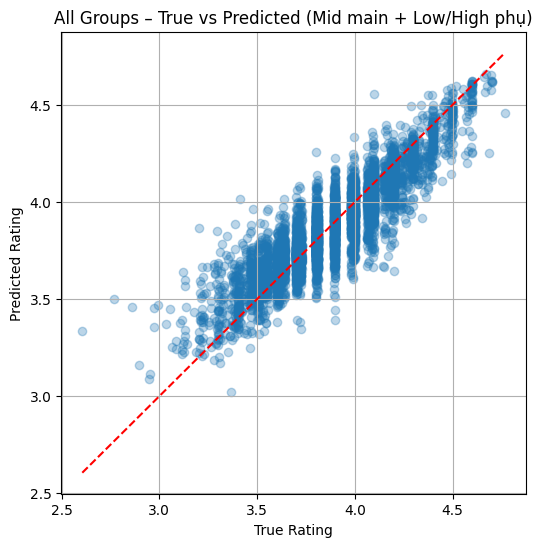

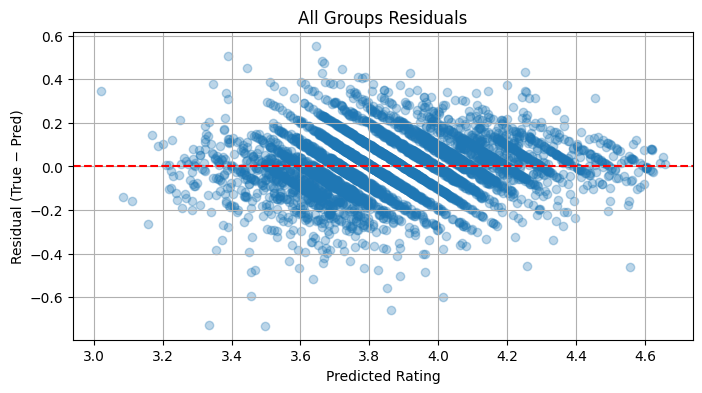

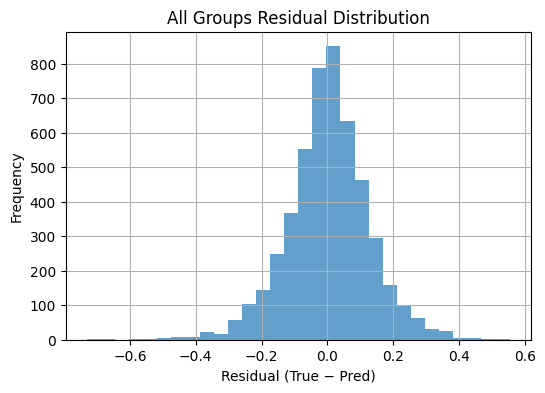

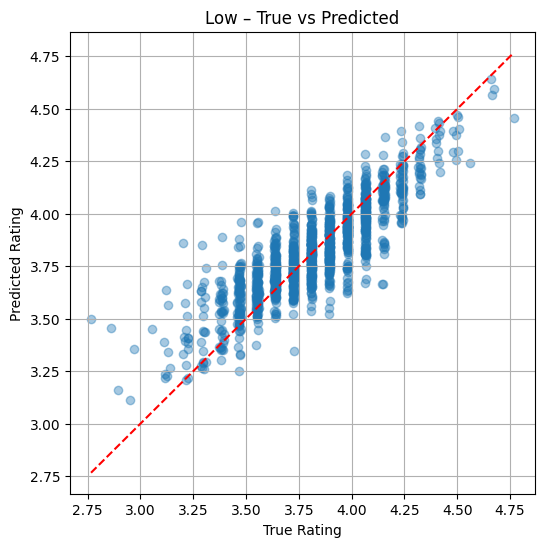

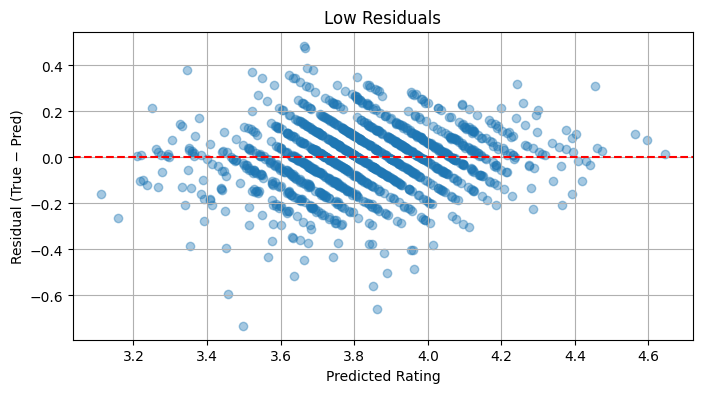

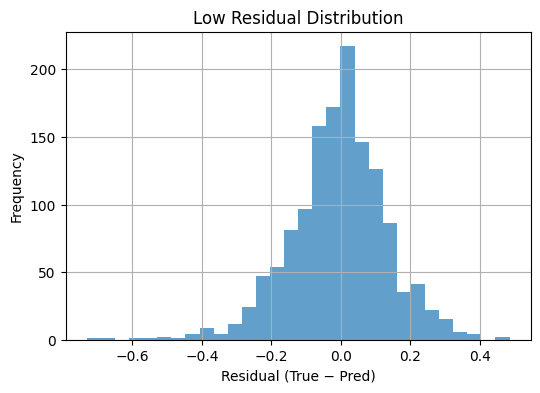

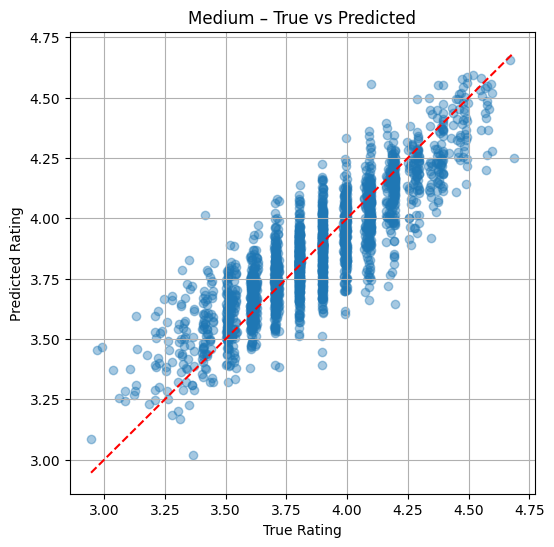

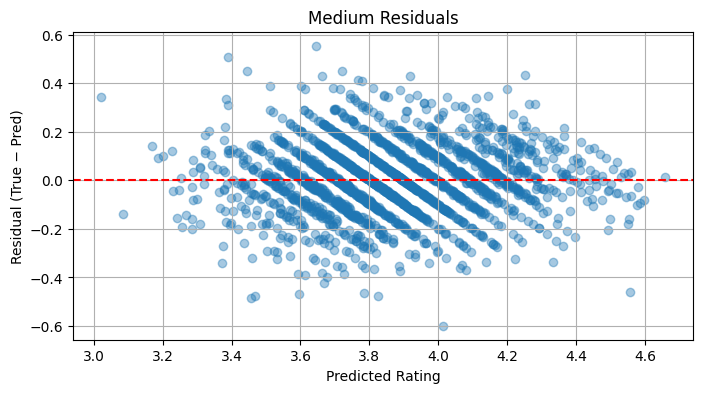

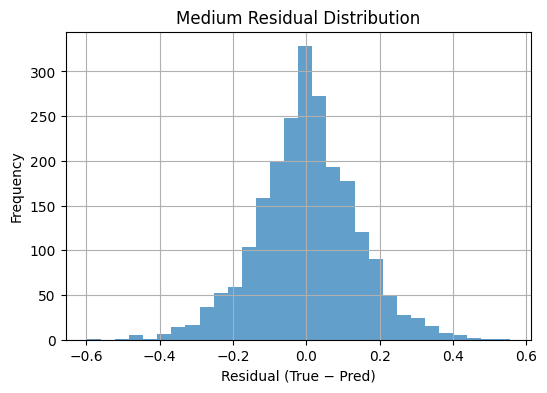

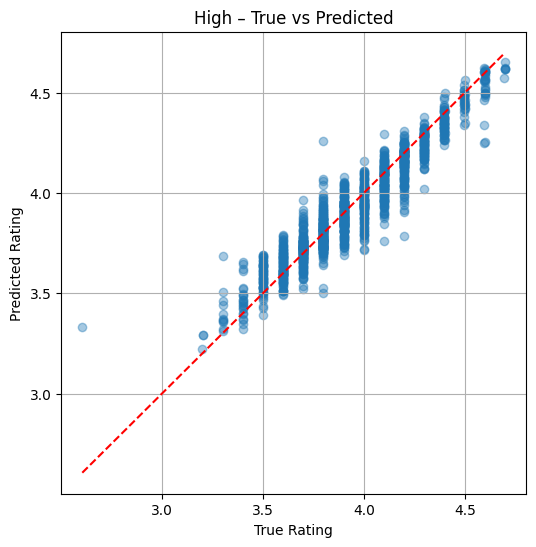

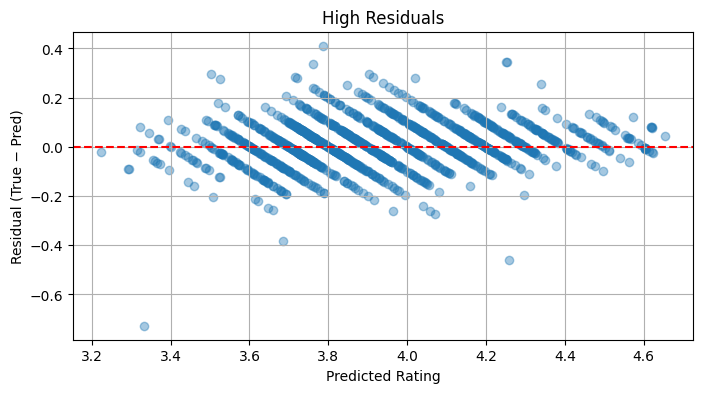

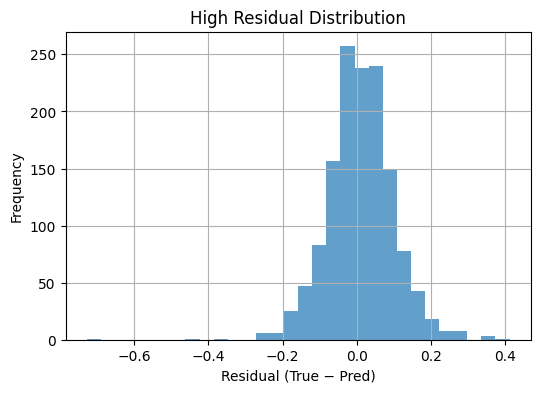

In [ ]:
# ===== VẼ BIỂU ĐỒ CHO test_df (sau khi đã có PredictedRating) =====

# 1) Biểu đồ chung – True vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(test_df["TrueRating"], test_df["PredictedRating"], alpha=0.3)
mn = min(test_df["TrueRating"].min(), test_df["PredictedRating"].min())
mx = max(test_df["TrueRating"].max(), test_df["PredictedRating"].max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("All Groups – True vs Predicted (Mid main + Low/High phụ)")
plt.grid(True)
plt.show()

# 2) Residuals chung
res_all = test_df["TrueRating"] - test_df["PredictedRating"]
plt.figure(figsize=(8,4))
plt.scatter(test_df["PredictedRating"], res_all, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Rating")
plt.ylabel("Residual (True − Pred)")
plt.title("All Groups Residuals")
plt.grid(True)
plt.show()

# 3) Residual distribution chung
plt.figure(figsize=(6,4))
plt.hist(res_all, bins=30, alpha=0.7)
plt.xlabel("Residual (True − Pred)")
plt.ylabel("Frequency")
plt.title("All Groups Residual Distribution")
plt.grid(True)
plt.show()

# 4) Riêng từng nhóm (Low/Medium/High)
for grp in ["Low", "Medium", "High"]:
    sub = test_df[test_df["ReliabilityGroup"] == grp]
    if len(sub) == 0:
        continue

    # (a) True vs Predicted – từng nhóm
    plt.figure(figsize=(6,6))
    plt.scatter(sub["TrueRating"], sub["PredictedRating"], alpha=0.4)
    mn = min(sub["TrueRating"].min(), sub["PredictedRating"].min())
    mx = max(sub["TrueRating"].max(), sub["PredictedRating"].max())
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("True Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"{grp} – True vs Predicted")
    plt.grid(True)
    plt.show()

    # (b) Residuals – từng nhóm
    res_grp = sub["TrueRating"] - sub["PredictedRating"]
    plt.figure(figsize=(8,4))
    plt.scatter(sub["PredictedRating"], res_grp, alpha=0.4)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Residual (True − Pred)")
    plt.title(f"{grp} Residuals")
    plt.grid(True)
    plt.show()

    # (c) Residual distribution – từng nhóm
    plt.figure(figsize=(6,4))
    plt.hist(res_grp, bins=30, alpha=0.7)
    plt.xlabel("Residual (True − Pred)")
    plt.ylabel("Frequency")
    plt.title(f"{grp} Residual Distribution")
    plt.grid(True)
    plt.show()


In [ ]:
def print_error_rate_by_group(test_df, group_name, threshold=0.2):
    df_group = test_df[test_df["ReliabilityGroup"] == group_name].copy()
    if df_group.shape[0] == 0:
        print(f"Không tìm thấy nhóm '{group_name}' trong test_df.")
        return

    df_group["abs_residual"] = np.abs(df_group["TrueRating"] - df_group["PredictedRating"])
    num_errors = (df_group["abs_residual"] > threshold).sum()
    total = df_group.shape[0]
    percent_error = num_errors / total * 100

    print(f"Nhóm {group_name}: có {num_errors} mẫu (trên {total}) có |residual| > {threshold}, "
          f"tương đương {percent_error:.2f}%")

print_error_rate_by_group(test_df, "High", threshold=0.2)
print_error_rate_by_group(test_df, "Medium", threshold=0.2)
print_error_rate_by_group(test_df, "Low", threshold=0.2)

Nhóm High: có 40 mẫu (trên 1370) có |residual| > 0.2, tương đương 2.92%
Nhóm Medium: có 299 mẫu (trên 2219) có |residual| > 0.2, tương đương 13.47%
Nhóm Low: có 183 mẫu (trên 1369) có |residual| > 0.2, tương đương 13.37%


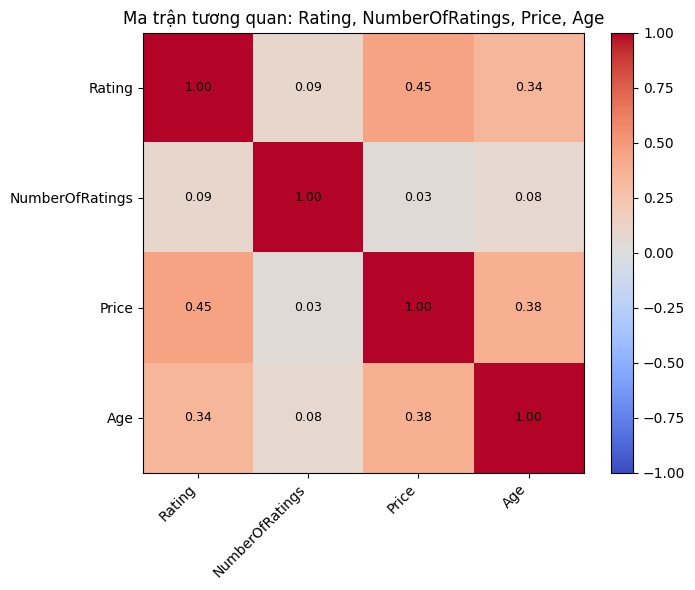

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 1) Load dữ liệu gốc và gộp =====
red       = pd.read_csv("Red.csv")
white     = pd.read_csv("White.csv")
rose      = pd.read_csv("Rose.csv")
sparkling = pd.read_csv("Sparkling.csv")
df_raw    = pd.concat([red, white, rose, sparkling], ignore_index=True)

# ===== 2) Tạo cột Age từ Year =====
def compute_age(year):
    try:
        return 2025 - int(year)
    except:
        return np.nan

df_raw["Age"] = df_raw["Year"].apply(compute_age)

# ===== 3) Chọn ra các cột numeric để tính correlation =====
corr_df = df_raw[["Rating", "NumberOfRatings", "Price", "Age"]].dropna().copy()

# ===== 4) Tính ma trận tương quan Pearson =====
corr_matrix = corr_df.corr()

# ===== 5) Vẽ heatmap bằng Matplotlib =====
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

labels = corr_matrix.columns.tolist()
n = len(labels)
plt.xticks(np.arange(n), labels, rotation=45, ha="right")
plt.yticks(np.arange(n), labels)

for i in range(n):
    for j in range(n):
        val = corr_matrix.iat[i, j]
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=9)

plt.title("Ma trận tương quan: Rating, NumberOfRatings, Price, Age")
plt.tight_layout()
plt.show()
